# Alternating Direction Method of Multipliers

Although gradient descent is a reliable algorithm that is guaranteed to converge, it is still slow. If we want to process larger sets of data (e.g. 3D imaging), have a live feed of DiffuserCam, or just want to process images more quickly, we need to tailor the algorithm more closely to the optical system involved. While this introduces more tuning parameters ("knobs" to turn), speed of reconstruction can be drastically improved. Here we present (without proof) the result of using <i>alternating direction method of multipiers (ADMM)</i> to  reconstruct the image.

For background on ADMM, please refer to sections 2 and 3 of: http://stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf. To understand this document, background knowledge from Chapters 5 (Duality) and 9 (Unconstrained minimization) from https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf may be necessary.

For a detailed derivation of the update steps as they apply to our system, refer to the companion documents to this notebook (specific sections will be referenced).

#### Generic setup code (load psf, etc.)

In [89]:
%matplotlib inline
import numpy as np
import numpy.fft as fft
from PIL import Image
import matplotlib.pyplot as plt
from IPython import display
import skimage.io as skio

In [90]:
"""Stuff that is normally in the config file"""
# psfname = "./psf_sample.tif"
psfname = '/Users/clarahung/Desktop/COSI/psf_rml_taped.tiff'
# 
# imgname = "./rawdata_hand_sample.tif"
imgname = '/Users/clarahung/repos/extendedfov/7-19-25/fwd/berk-rml-taped-psf-measurement.png'
# 

# Downsampling factor (used to shrink images)
f = 0.25

# Hyper-parameters in the ADMM implementation (like step size in GD)
mu1 = 1e-7
mu2 = 1e-5
mu3 = 4e-5
tau = 1e-4 / np.sqrt(3)

# Number of iterations
iters = 5

In [91]:
def loadData(show_im=True):
    psf = skio.imread(psfname)
    psf = np.array(psf, dtype='float32')
    data = skio.imread(imgname)
    data = np.array(data, dtype='float32')

    
    if len(data.shape) == 2:
        # pad to 3 channels
        data =  np.repeat(data[..., None], 3, axis=2)
    if len(psf.shape) == 2:
        # pad to 3 channels
        psf =  np.repeat(psf[..., None], 3, axis=2)
    # remove alpha channel
    if data.shape[-1] > 3:
        data = data[:, :, 0:3]
 
    """In the picamera, there is a non-trivial background 
    (even in the dark) that must be subtracted"""

    # TODO: adjust for our data
    bg = skio.imread('/Users/clarahung/repos/lensless-dataset/rml_darkframe.tiff')
    # bg = np.mean(psf[5:15,5:15])
    psf -= bg
    data -= bg
    
    """Resize to a more manageable size to do reconstruction on. 
    Because resizing is downsampling, it is subject to aliasing 
    (artifacts produced by the periodic nature of sampling). Demosaicing is an attempt
    to account for/reduce the aliasing caused. In this application, we do the simplest
    possible demosaicing algorithm: smoothing/blurring the image with a box filter"""
    
    def resize(img, factor):
        num = int(-np.log2(factor))
        for i in range(num):
            img = 0.25*(img[::2,::2,...]+img[1::2,::2,...]+img[::2,1::2,...]+img[1::2,1::2,...])
        return img
    
    
    psf = resize(psf, f)
    data = resize(data, f)
    
    """Now we normalize the images so they have the same total power. Technically not a
    necessary step, but the optimal hyperparameters are a function of the total power in 
    the PSF (among other things), so it makes sense to standardize it"""
    # this was for grayscale images
    # psf /= np.linalg.norm(psf.ravel())
    # data /= np.linalg.norm(data.ravel())

    def normalize(x):
        """normalize image to be between 0-1"""
        return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))
    
    psf = normalize(psf)
    data = normalize(data)
    print(np.min(psf), np.max(psf))


    
    if show_im:
        fig1 = plt.figure()
        plt.imshow(psf, cmap='gray')
        plt.title('PSF')
#         display.display(fig1)
        fig2 = plt.figure()
        plt.imshow(data, cmap='gray')
        plt.title('Raw data')
#         display.display(fig2)
    return psf, data

0.0 1.0


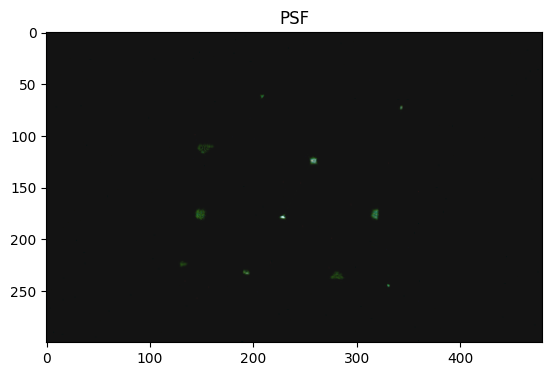

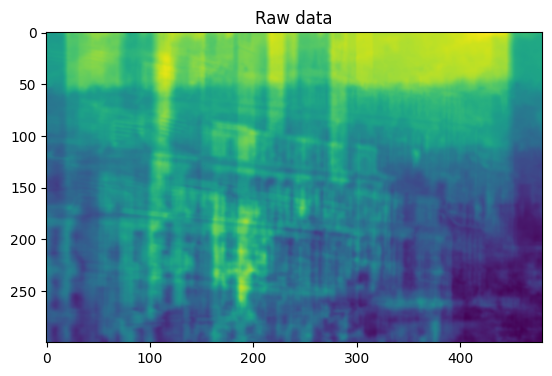

In [92]:
"""The "uncropped" size of the image. As with the gradient descent, we pad the images 
so that convolution is linear instead of circular"""
psf, data = loadData(True)
sensor_size = np.array(psf.shape)

# change from 2*sensor_size for color
full_size = (2*sensor_size[0], 2*sensor_size[1], sensor_size[2])

In [93]:
def SoftThresh(x, tau):
    # numpy automatically applies functions to each element of the array
    return np.sign(x)*np.maximum(0, np.abs(x) - tau)

def VectorSoftThresh(x, tau, axis=-1):
    """
    Vector soft thresholding across the specified axis.
    For RGB: x.shape = (H, W, 3), axis=-1
    For gradients: x.shape = (H, W, 2), axis=-1
    """
    norm = np.sqrt(np.sum(x**2, axis=(2, 3), keepdims=True))
    # np.linalg.norm(x, axis=axis, keepdims=True)
    scale = np.maximum(0, norm - tau) / (norm + 1e-8)  # Avoid divide-by-zero
    return scale * x

In [94]:
# def Psi(v):
#     """
#     Compute forward differences per color channel.
#     Returns (H, W, 6):
#     dy_R, dx_R, dy_G, dx_G, dy_B, dx_B
#     """
#     grads = []
#     for c in range(3):
#         dy = np.roll(v[..., c], 1, axis=0) - v[..., c]
#         dx = np.roll(v[..., c], 1, axis=1) - v[..., c]
#         grads.extend([dy, dx])
#     return np.stack(grads, axis=2)

# def PsiT(U):
#     """
#     Compute divergence (adjoint of Psi) per color channel.
#     Input U shape: (H, W, 6)
#     Output shape: (H, W, 3)
#     """
#     div = []
#     for c in range(3):
#         dy = U[..., 2*c]      # vertical differences
#         dx = U[..., 2*c + 1]  # horizontal differences
#         ddy = np.roll(dy, -1, axis=0) - dy
#         ddx = np.roll(dx, -1, axis=1) - dx
#         div.append(ddy + ddx)
#     return np.stack(div, axis=2)

In [95]:
def Psi(v):
    Psi_v = np.stack((np.roll(v,1,axis=0) - v, np.roll(v, 1, axis=1) - v), axis=2)
    print("Psi: ", Psi_v.shape)
    return Psi_v
def PsiT(U):
    diff1 = np.roll(U[...,0, :],-1,axis=0) - U[...,0, :]
    diff2 = np.roll(U[...,1, :],-1,axis=1) - U[...,1, :]
    print("PsiT: ", diff1.shape)
    return diff1 + diff2

In [96]:
def U_update(eta, image_est, tau):
    return VectorSoftThresh(Psi(image_est) + eta/mu2, tau/mu2)

In [97]:
def X_update(xi, image_est, H_fft, sensor_reading, X_divmat):
    return X_divmat * (xi + mu1*M(image_est, H_fft) + CT(sensor_reading))

In [98]:
def M(vk, H_fft):
    return np.real(fft.fftshift(fft.ifft2(fft.fft2(fft.ifftshift(vk, axes=(0, 1)), axes=(0, 1))*H_fft, axes=(0, 1)), axes=(0, 1)))

In [99]:
def C(M):
    # Image stored as matrix (row-column rather than x-y)
    top = (full_size[0] - sensor_size[0])//2
    bottom = (full_size[0] + sensor_size[0])//2
    left = (full_size[1] - sensor_size[1])//2
    right = (full_size[1] + sensor_size[1])//2
    return M[top:bottom,left:right, ...]

def CT(b):
    v_pad = ((full_size[0] - sensor_size[0])//2)
    h_pad = ((full_size[1] - sensor_size[1])//2)

    # add (0, 0) for color channel
    return np.pad(b, ((v_pad, v_pad), (h_pad, h_pad), (0, 0)), 'constant', constant_values=(0,0))

In [100]:
def precompute_X_divmat(): 
    """Only call this function once! 
    Store it in a variable and only use that variable 
    during every update step"""
    return 1./(CT(np.ones(sensor_size)) + mu1)

In [101]:
def W_update(rho, image_est):
    return np.maximum(rho/mu3 + image_est, 0)

In [102]:
def MT(x, H_fft):
    x_zeroed = fft.ifftshift(x, axes=(0, 1))
    print("x_zeroed", x_zeroed.shape)
    print("H_fft", H_fft.shape)
    return np.real(fft.fftshift(fft.ifft2(fft.fft2(x_zeroed, axes=(0, 1)) * np.conj(H_fft), axes=(0, 1)), axes=(0, 1)))

In [103]:
def r_calc(w, rho, u, eta, x, xi, H_fft):
    return (mu3*w - rho)+PsiT(mu2*u - eta) + MT(mu1*x - xi, H_fft)

def V_update(w, rho, u, eta, x, xi, H_fft, R_divmat):
    freq_space_result = R_divmat*fft.fft2( fft.ifftshift(r_calc(w, rho, u, eta, x, xi, H_fft), axes=(0, 1)), axes=(0, 1) )
    return np.real(fft.fftshift(fft.ifft2(freq_space_result, axes=(0, 1)), axes=(0, 1)))

In [104]:
def precompute_PsiTPsi():
    PsiTPsi = np.zeros(full_size[:2]) # laplacian is a spatial operator
    print("PsiTPsi: ", PsiTPsi.shape)
    PsiTPsi[0,0] = 4
    PsiTPsi[0,1] = PsiTPsi[1,0] = PsiTPsi[0,-1] = PsiTPsi[-1,0] = -1
    PsiTPsi = fft.fft2(PsiTPsi, axes=(0, 1))
    return PsiTPsi

In [105]:
def precompute_R_divmat(H_fft, PsiTPsi): 
    """Only call this function once! 
    Store it in a variable and only use that variable 
    during every update step"""
    MTM_component = mu1*(np.abs(np.conj(H_fft)*H_fft))
    PsiTPsi_component = mu2*np.abs(PsiTPsi)
    id_component = mu3
    """This matrix is a mask in frequency space. So we will only use
    it on images that have already been transformed via an fft"""
    return 1./(MTM_component + PsiTPsi_component + id_component)

In [106]:
def xi_update(xi, V, H_fft, X):
    return xi + mu1*(M(V,H_fft) - X)

def eta_update(eta, V, U):
    return eta + mu2*(Psi(V) - U)

def rho_update(rho, V, W):
    return rho + mu3*(V - W)

In [107]:
def init_Matrices(H_fft):
    X = np.zeros(full_size)
    U = np.zeros((full_size[0], full_size[1], 2, 3)) # originally init to 2 (why?), changed to 3
    V = np.zeros(full_size)
    W = np.zeros(full_size)

    xi = np.zeros_like(M(V,H_fft))
    eta = np.zeros_like(Psi(V))
    rho = np.zeros_like(W)
    return X,U,V,W,xi,eta,rho

In [108]:
def precompute_H_fft(psf):
    # This takes in the PSF, which is (H, W, 3)
    return fft.fft2(fft.ifftshift(CT(psf), axes=(0, 1)), axes=(0, 1))

In [109]:
def ADMMStep(X,U,V,W,xi,eta,rho, precomputed):
    H_fft, data, X_divmat, R_divmat = precomputed
    U = U_update(eta, V, tau)
    X = X_update(xi, V, H_fft, data, X_divmat)
    V = V_update(W, rho, U, eta, X, xi, H_fft, R_divmat)
    W = W_update(rho, V)
    xi = xi_update(xi, V, H_fft, X)
    eta = eta_update(eta, V, U)
    rho = rho_update(rho, V, W)
    
    return X,U,V,W,xi,eta,rho

In [110]:
def runADMM(psf, data):
    H_fft = precompute_H_fft(psf)
    X,U,V,W,xi,eta,rho = init_Matrices(H_fft)
    X_divmat = precompute_X_divmat()
    PsiTPsi = precompute_PsiTPsi()[..., None] # broadcast
    R_divmat = precompute_R_divmat(H_fft, PsiTPsi)
    
    for i in range(iters):
        X,U,V,W,xi,eta,rho = ADMMStep(X,U,V,W,xi,eta,rho, [H_fft, data, X_divmat, R_divmat])
        if i % 1 == 0:
            image = C(V)
            image[image<0] = 0
            f = plt.figure(1)
            plt.imshow(image, cmap='gray')
            plt.title('Reconstruction after iteration {}'.format(i))
            display.display(f)
            # display.clear_output(wait=True)
    return image

Psi:  (600, 960, 2, 3)
PsiTPsi:  (600, 960)
Psi:  (600, 960, 2, 3)
PsiT:  (600, 960, 3)
x_zeroed (600, 960, 3)
H_fft (600, 960, 3)
Psi:  (600, 960, 2, 3)


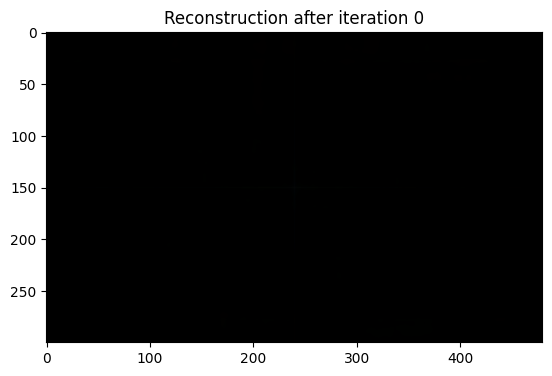

Psi:  (600, 960, 2, 3)
PsiT:  (600, 960, 3)
x_zeroed (600, 960, 3)
H_fft (600, 960, 3)
Psi:  (600, 960, 2, 3)


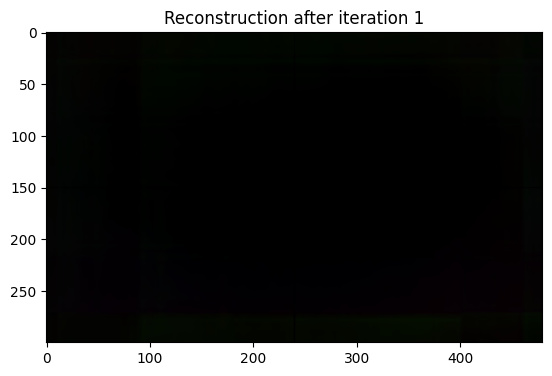

Psi:  (600, 960, 2, 3)
PsiT:  (600, 960, 3)
x_zeroed (600, 960, 3)
H_fft (600, 960, 3)
Psi:  (600, 960, 2, 3)


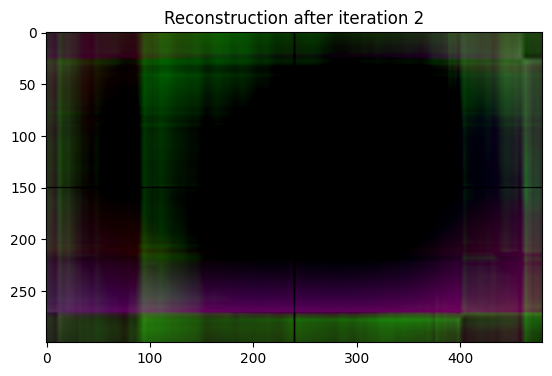

Psi:  (600, 960, 2, 3)
PsiT:  (600, 960, 3)
x_zeroed (600, 960, 3)
H_fft (600, 960, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..5.867535719481428].


Psi:  (600, 960, 2, 3)


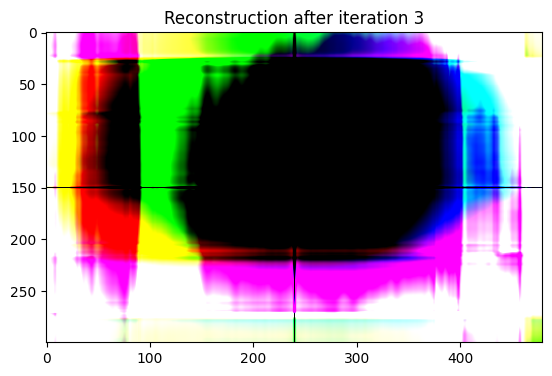

Psi:  (600, 960, 2, 3)
PsiT:  (600, 960, 3)
x_zeroed (600, 960, 3)
H_fft (600, 960, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..83.3039083583576].


Psi:  (600, 960, 2, 3)


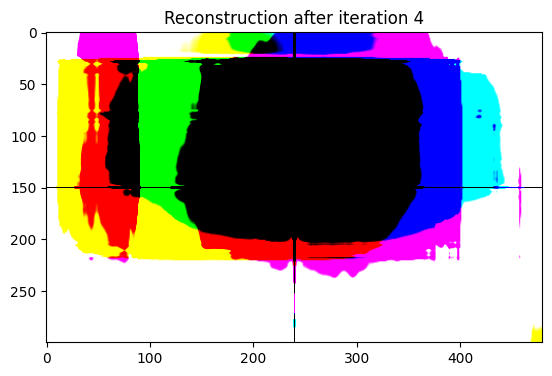

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..83.3039083583576].


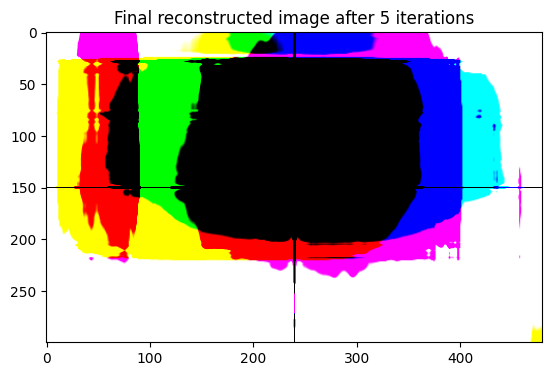

In [111]:
#psf, data = loadData(True)
final_im = runADMM(psf, data)
# print(final_im.shape)
# print(np.min(final_im), np.max(final_im))
plt.imshow(final_im, cmap='gray')
plt.title('Final reconstructed image after {} iterations'.format(iters))
display.display()
